# Homework 2

# Problem 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

dataset = pd.read_csv("http://pitt.edu/~kpele/daily_citi_bike_trip_counts_and_weather.csv")

In [2]:
# create columns that have the various powers of the max temperature variable
dataset['maxtemp2'] = pow(dataset['max_temperature'],2)
dataset['maxtemp3'] = pow(dataset['max_temperature'],3)
dataset['maxtemp4'] = pow(dataset['max_temperature'],4)
dataset['maxtemp5'] = pow(dataset['max_temperature'],5)

# split the dataset to 60-20-20 for train, validation, test sets respectively
train, validate, test = np.split(dataset.sample(frac=1), [int(.6*len(dataset)), int(.8*len(dataset))])

We will now train each polynomial model

Validation error:  [11849.738961296598, 7527.7243479251965, 7370.668830038442, 7081.106341819977, 7092.280840882208, 7091.660802183557]


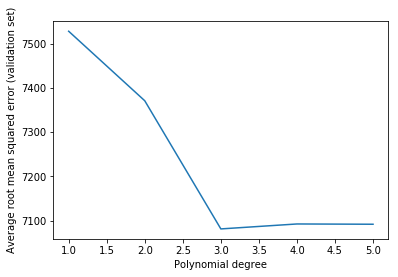

In [3]:
# constant model
model0 = ols('trips~1',data=train).fit()
# linear
model1 = ols('trips~max_temperature',data = train).fit()
# square
model2 = ols('trips~max_temperature+maxtemp2',data = train).fit()
# cubic
model3 = ols('trips~max_temperature+maxtemp2+maxtemp3',data = train).fit()
# 4th power
model4 = ols('trips~max_temperature+maxtemp2+maxtemp3+maxtemp4',data = train).fit()
# 5th power
model5 = ols('trips~max_temperature+maxtemp2+maxtemp3+maxtemp4+maxtemp5',data = train).fit()

## calculate the mean root squared error on the validation set for each model
validation_error = []
validation_error.append(np.sqrt(np.mean(pow(model0.predict(validate)-validate.trips,2))))
validation_error.append(np.sqrt(np.mean(pow(model1.predict(validate)-validate.trips,2))))
validation_error.append(np.sqrt(np.mean(pow(model2.predict(validate)-validate.trips,2))))
validation_error.append(np.sqrt(np.mean(pow(model3.predict(validate)-validate.trips,2))))
validation_error.append(np.sqrt(np.mean(pow(model4.predict(validate)-validate.trips,2))))
validation_error.append(np.sqrt(np.mean(pow(model5.predict(validate)-validate.trips,2))))

print("Validation error: ", validation_error)
# plot the validation error as a function of the polynomial degree of the model

fig = plt.figure()
ax = fig.add_subplot(111)
# we do not plot the constant model for making sure the scale of the y-axis allows to see the differences
plt.plot(range(1,6),validation_error[1:6])
ax.set_xlabel('Polynomial degree')
ax.set_ylabel('Average root mean squared error (validation set)')
plt.show()

As we can see the cubic model has the smallest RMSE in the validation set and hence, this is our choice. In order to report the performance of the model we have to calculate the RMSE on the test set. 

In [5]:
print("The performance of the best model is: ",np.sqrt(np.mean(pow(model3.predict(test)-test.trips,2))))

The performance of the best model is:  7482.92893908223


Visualizations: 

* For the daily trips taken we will use a line plot for time-series (x-axis: time/day, y-axis: # of trips)
* For the daily trips and max temperature we will use a scatter plot
* For the relationship between trips, day of the week and month we will use a heatmap

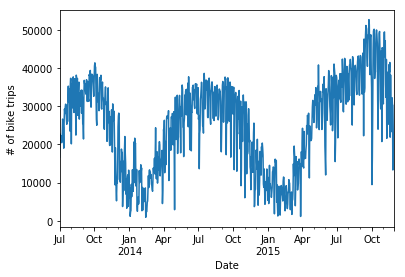

In [6]:
# daily trips

from pandas import Series
series = Series.from_csv('http://pitt.edu/~kpele/daily_citi_bike_trip_counts_and_weather.csv', header=0)
fig = plt.figure()
ax = fig.add_subplot(111)
series.plot()
ax.set_xlabel('Date')
ax.set_ylabel('# of bike trips')
plt.show()

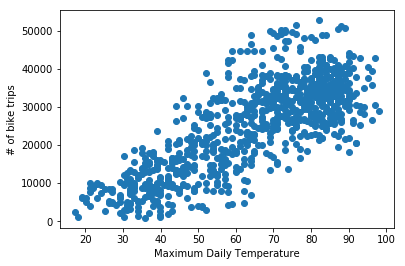

In [7]:
# daily trips-vs-max temperature

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot( 'max_temperature', 'trips', data=dataset, linestyle='none', marker='o')
ax.set_xlabel('Maximum Daily Temperature')
ax.set_ylabel('# of bike trips')
plt.show()

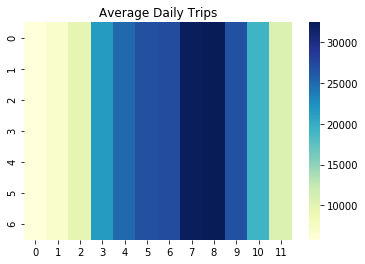

In [8]:
# daily trips, day of week and month

avg_trips = [[0]*12]*7

for dow in range(7):
    for month in range(1,13):
        mask = (dataset['dow'] == dow) & (dataset['month'] == month)
        tmp = dataset[mask]
        avg_trips[dow][month-1] = np.mean(tmp["trips"])
        
#plt.imshow(avg_trips, cmap='YlGn', cbarlabel="Average Daily Trips")
fig, ax = plt.subplots()
ax.set_xlabel('Month')
ax.set_ylabel('Day of the Week')
ax.set_title("Average Daily Trips")
ax = sns.heatmap(avg_trips, cmap="YlGnBu")

# Problem 2 


We begine by calculating the number of reviews for each book and their (raw) average rating.

In [9]:
books = pd.read_csv("https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv")

df = pd.DataFrame(columns=['book','nreviews', 'totscore', 'avgscore']) 


for z, tmp in books.groupby('book_id'):
    df = df.append({'book' : z, 'nreviews' : len(tmp), 'totscore' : sum(tmp['rating']), 'avgscore' : float(sum(tmp['rating']))/len(tmp)},ignore_index=True)

We calculate the bayesian average for every book. For this we will need the average of the average ratings and the average number of reviews for every book.

In [10]:
avg_rating = np.mean(df.avgscore)
avg_nrtgs = np.mean(df.nreviews)

# calculated the bayesian avg for every book
bayes_avg = []

for b in range(len(df)):
    bayes_avg.append(((avg_nrtgs*avg_rating)+(df.iloc[b]['avgscore']*df.iloc[b]['nreviews']))/(avg_nrtgs+df.iloc[b]['nreviews']))
    
df['bayes_avg'] = bayes_avg
df['label'] = np.sign(df['nreviews']-avg_nrtgs)

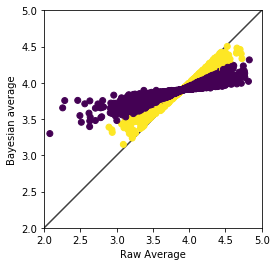

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(x=df['avgscore'],y=df['bayes_avg'],c=df['label'])
plt.ylim((2,5))
plt.xlim((2,5))
ax.set_xlabel('Raw Average')
ax.set_ylabel('Bayesian average')
# the following code adds the y=x line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

From what we see, for the points for which we have more reviews than average (yellow) points, the bayesian average and the raw average are very close to each other (they practically lay on the y=x line), while for points with less reviews than average, the two means differ. In the latter case, the bayesian average will pull the raw average closer to the "avg_rating". 